# Chart Recommender
This file provides an example of running the single chart recommender.     
The input is a CSV file containing the data.     

### Single-Chart Recommender
The output is the recommended charts, described by the column selection and chart type.     

### MV Recommender
The output is the recommended MVs, described as a list of charts.

Notes of limitations:
- A chart can encode a max number of 4 data columns.
- A MV can have a max number of 12 charts.
- The predicted chart type is limited to ('area', 'bar', 'scatter', 'line', 'pie')

In [1]:
import pandas as pd
import json
import numpy as np
import itertools
import sys
import re

import torch
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
import torch.nn.functional as nnf

from model.encodingModel_copy import ChartTypeNN, ChartTypeLSTM, ScoreNetLSTM
# from utils.helper import softmax, get_data_feature_by_column, get_embed_feature_by_column, get_all_charts_scores, charts_to_features
from utils import featureExtractor
from utils.ChartRecommender_copy import ChartRecommender

## Load pretrained word-embedding model

In [2]:
word_embedding_model_path = 'utils/en-50d-200000words.vec'

word_embedding_dict = {}
with open(word_embedding_model_path, encoding='utf-8') as file_in:
    lines = []
    for idx, line in enumerate(file_in):
        if idx == 0: ## line 0 is invalid
            continue 
        word, *features = line.split()
        word_embedding_dict[word] = np.array(features)

## Load trained single-chart assessment model and chart type prediction model

In [3]:
gpu = torch.device('cuda:0')

column_score_model = ScoreNetLSTM(input_size=96, seq_length = 4, batch_size=2, pack = True).to(gpu)
column_score_model.load_state_dict(torch.load('trainedModel/singleChartModel.pt', map_location=gpu))
column_score_model.eval()

# 暂时不需要图表类型预测模型
# chart_type_model = ChartTypeLSTM(input_size = 96, hidden_size = 400, seq_length = 4, num_class = 9, bidirectional = True).to(gpu)
# chart_type_model.load_state_dict(torch.load('trainedModel/chartType.pt', map_location=gpu))
# chart_type_model.eval()

ScoreNetLSTM(
  (lstm): LSTM(96, 200, batch_first=True)
  (linear): Linear(in_features=800, out_features=1, bias=True)
)

In [9]:
for name in column_score_model.state_dict():
  print(name)

lstm.weight_ih_l0
lstm.weight_hh_l0
lstm.bias_ih_l0
lstm.bias_hh_l0
linear.weight
linear.bias


## Single chart recommender
Return a DataFrame:
- indices: the column indices encoded by this chart
- column_selection_score: the predicted score for the column selection. Min-max normed.
- chart type: the chart type ('area', 'bar', 'scatter', 'line', 'pie')
- chart_type_prob: the likelihood that the selected columns are encoded by the chart type
- final_score: the overall score which is column_selection_score * chart_type_prob

In [4]:
filename = 'csv/cars.csv'
file = pd.read_csv(filename)

In [5]:
chartRecommender = ChartRecommender(filename, word_embedding_dict, column_score_model)

In [6]:
## rank the results by the final_score
scores = pd.DataFrame.from_records(chartRecommender.charts)
scores.sort_values(by='column_selection_score', ascending = False)

,indices,column_selection_score,column_distance
4,"(0, 5)",0.895006,0.104994
22,"(3, 5)",0.895006,0.104994
8,"(1, 2)",0.894982,0.105018
27,"(4, 6)",0.894968,0.105032
9,"(1, 3)",0.586100,0.413900
29,"(4, 8)",0.540333,0.459667
26,"(4, 5)",0.503448,0.496552
16,"(2, 4)",0.500000,0.500000
25,"(3, 8)",0.500000,0.500000
30,"(5, 6)",0.500000,0.500000


In [7]:
distance_matrix = np.zeros((len(file.columns), len(file.columns)))
for index, series in scores.iterrows():
    col_1, col_2 = series['indices']
    distance_matrix[col_2, col_1] = distance_matrix[col_1, col_2] = float(series['column_distance'])
distance_matrix

array([[0.        , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.10499358, 0.5       , 0.50013078, 0.89500642],
       [0.5       , 0.        , 0.10501815, 0.41389981, 0.89500166,
        0.89500642, 0.5       , 0.50000003, 0.5       ],
       [0.5       , 0.10501815, 0.        , 0.89500642, 0.49999998,
        0.5       , 0.89495118, 0.5       , 0.89500642],
       [0.5       , 0.41389981, 0.89500642, 0.        , 0.5       ,
        0.10499358, 0.5       , 0.5       , 0.5       ],
       [0.5       , 0.89500166, 0.49999998, 0.5       , 0.        ,
        0.49655187, 0.10503203, 0.50000001, 0.45966699],
       [0.10499358, 0.89500642, 0.5       , 0.10499358, 0.49655187,
        0.        , 0.5       , 0.5       , 0.50000081],
       [0.5       , 0.5       , 0.89495118, 0.5       , 0.10503203,
        0.5       , 0.        , 0.50007075, 0.5       ],
       [0.50013078, 0.50000003, 0.5       , 0.5       , 0.50000001,
        0.5       , 0.50007075, 0.        , 0.89500642],


<AxesSubplot:>

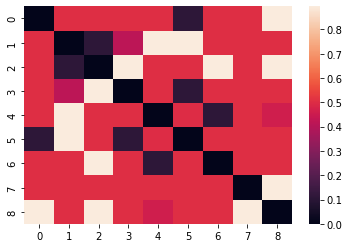

In [8]:
import seaborn as sns

sns.heatmap(distance_matrix)

In [17]:
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
# clustering = DBSCAN(metric="precomputed", eps=0.25, min_samples=1).fit(distance_matrix)
# display(clustering.labels_)

clustering = GaussianMixture(n_components=3).fit_predict()

file

array([0, 1, 1, 0, 2, 0, 2, 3, 4], dtype=int64)

,Name,Miles_per_Gallon,Cylinders,Displacement,Horsepower,Weight_in_lbs,Acceleration,Year,Origin
0,chevrolet chevelle malibu,18.0,8,307.0,130.0,3504,12.0,1970,USA
1,buick skylark 320,15.0,8,350.0,165.0,3693,11.5,1970,USA
2,plymouth satellite,18.0,8,318.0,150.0,3436,11.0,1970,USA
3,amc rebel sst,16.0,8,304.0,150.0,3433,12.0,1970,USA
4,ford torino,17.0,8,302.0,140.0,3449,10.5,1970,USA
...,...,...,...,...,...,...,...,...,...
401,ford mustang gl,27.0,4,140.0,86.0,2790,15.6,1982,USA
402,vw pickup,44.0,4,97.0,52.0,2130,24.6,1982,Europe
403,dodge rampage,32.0,4,135.0,84.0,2295,11.6,1982,USA
404,ford ranger,28.0,4,120.0,79.0,2625,18.6,1982,USA


In [37]:
from sklearn.manifold import TSNE, MDS

# col_embedding = MDS(metric='precomputed').fit_transform(distance_matrix)
col_embedding = MDS(dissimilarity='precomputed').fit_transform(distance_matrix)
col_embedding.shape

(9, 2)

<AxesSubplot:>

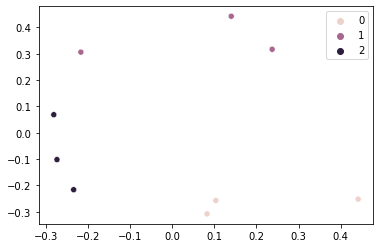

In [43]:
from sklearn.mixture import GaussianMixture

clustering = GaussianMixture(n_components=3).fit_predict(col_embedding)

sns.scatterplot(x=col_embedding[:,0],y=col_embedding[:,1], hue=clustering)

In [44]:
display(clustering)
file

array([2, 1, 1, 2, 0, 2, 0, 1, 0], dtype=int64)

,Name,Miles_per_Gallon,Cylinders,Displacement,Horsepower,Weight_in_lbs,Acceleration,Year,Origin
0,chevrolet chevelle malibu,18.0,8,307.0,130.0,3504,12.0,1970,USA
1,buick skylark 320,15.0,8,350.0,165.0,3693,11.5,1970,USA
2,plymouth satellite,18.0,8,318.0,150.0,3436,11.0,1970,USA
3,amc rebel sst,16.0,8,304.0,150.0,3433,12.0,1970,USA
4,ford torino,17.0,8,302.0,140.0,3449,10.5,1970,USA
...,...,...,...,...,...,...,...,...,...
401,ford mustang gl,27.0,4,140.0,86.0,2790,15.6,1982,USA
402,vw pickup,44.0,4,97.0,52.0,2130,24.6,1982,Europe
403,dodge rampage,32.0,4,135.0,84.0,2295,11.6,1982,USA
404,ford ranger,28.0,4,120.0,79.0,2625,18.6,1982,USA


## MV Recommender
Return a MV.
- a MV is describled as a list of charts (corresponding to each record in the above charts_df)
- current_mv: optional. 
- max_charts: number of charts in the returned MV

In [6]:
## load model
mv_model = ScoreNetLSTM(input_size=9, seq_length = 12).to(gpu)
mv_model.load_state_dict(torch.load('trainedModel/mvModel.pt', map_location=gpu))
mv_model.eval()

ScoreNetLSTM(
  (lstm): LSTM(9, 200, batch_first=True)
  (linear): Linear(in_features=2400, out_features=1, bias=True)
)

In [7]:
chartRecommender = ChartRecommender('csv/penguins.csv', 
                                    word_embedding_dict, column_score_model, chart_type_model)

In [8]:
## Recommending an MV conditioned on current_mv
current_mv = [{'indices': (1,), 'chart_type': 'pie'}]
chartRecommender.recommend_mv(mv_model, current_mv = current_mv, max_charts = len(current_mv) + 1)

[{'indices': (1,), 'chart_type': 'pie'},
 {'indices': (0, 1, 6),
  'column_selection_score': 0.9539935795810937,
  'chart_type': 'bar',
  'chart_type_prob': 0.9747986769832964,
  'final_score': 0.9299516792262091}]

In [9]:
## Recommending an MV without conditions
chartRecommender.recommend_mv(mv_model, current_mv = [], max_charts = 4)

[{'indices': (2, 3, 5),
  'column_selection_score': 0.1708782435156015,
  'chart_type': 'line',
  'chart_type_prob': 0.999996129577233,
  'final_score': 0.17087758214455742},
 {'indices': (0, 1, 6),
  'column_selection_score': 0.9539935795810937,
  'chart_type': 'bar',
  'chart_type_prob': 0.9747986769832964,
  'final_score': 0.9299516792262091},
 {'indices': (2, 4, 5),
  'column_selection_score': 0.17105416842913918,
  'chart_type': 'line',
  'chart_type_prob': 0.9999778765252179,
  'final_score': 0.17105038411655754},
 {'indices': (3, 4, 5),
  'column_selection_score': 0.17125484069439123,
  'chart_type': 'line',
  'chart_type_prob': 0.9998294031600292,
  'final_score': 0.17122562515973908}]